In [1]:
import numpy as np
import math
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy 

In [2]:
def splits_to_regions_binary(row, splits):
    num = 0
    for v in splits:
        num = 2 * num + row[v]
    return num

In [3]:
pa_precincts = gpd.read_file('../data/precincts/pa/')
pa_precincts = pa_precincts.to_crs("EPSG:4269")
pa_precincts['GEOID'] = pa_precincts['GEOID'].astype(str)

print(pa_precincts.shape)
pa_precincts.sample(n=5)

(9150, 20)


,"loc, prec",GEOID,county_id,precinct,G18DemSen,G18RepSen,G18LibSen,G18GreSen,G18IndSen,G18DemGov,G18RepGov,G18LibGov,G18GreGov,G18IndGov,G18DemHOR,G18RepHOR,G18LibHOR,G18GreHOR,G18IndHOR,geometry
8359,"Union County, mifflinburg west",42119,Union County,mifflinburg west,193.0,362.0,0.0,0.0,0.0,225.0,321.0,9.0,8.0,1.0,155.0,408.0,0.0,0.0,0.0,"POLYGON Z ((-77.06209 40.91402 0.00000, -77.06..."
3832,"Elk County, johnsonburg 1",42047,Elk County,johnsonburg 1,108.0,119.0,3.0,1.0,0.0,88.0,137.0,3.0,1.0,0.0,78.0,153.0,0.0,0.0,0.0,"POLYGON Z ((-78.69754 41.49728 0.00000, -78.69..."
5329,"Lycoming County, porter",42081,Lycoming County,porter,168.0,417.0,3.0,1.0,0.0,171.0,405.0,6.0,6.0,0.0,122.0,466.0,0.0,0.0,0.0,"POLYGON Z ((-77.31348 41.21313 0.00000, -77.31..."
7819,"Philadelphia County, 61~11",42101,Philadelphia County,61~11,304.0,12.0,0.0,0.0,0.0,300.0,13.0,2.0,1.0,0.0,298.0,14.0,0.0,0.0,0.0,"POLYGON Z ((-75.12208 40.04167 0.00000, -75.12..."
1203,"Allegheny County, south fayette 1",42003,Allegheny County,south fayette 1,236.0,176.0,4.0,0.0,0.0,245.0,170.0,0.0,1.0,0.0,258.0,0.0,0.0,0.0,20.0,"POLYGON Z ((-80.13332 40.33382 0.00000, -80.13..."


In [4]:
pa_bg = gpd.read_file('../data/geography/pa/cbg_shapefile')
pa_bg['GEOID'] = pa_bg['GEOID'].astype(str)
voting_pop = pd.read_csv("../data/population/pa/pop.csv")
voting_pop['GEOID'] = voting_pop['GEO_ID'].apply(lambda x: x.split("US")[1])
voting_pop['GEOID'] = voting_pop['GEOID'].astype(str)
pa_bg = pa_bg.merge(voting_pop, on="GEOID")

# pa_bg = pa_bg.to_crs("EPSG:2271")
pa_bg['REPRESENTATIVE_POINT'] =  pa_bg.representative_point() # https://gis.stackexchange.com/a/414263
pa_bg['RP_LON'] = pa_bg['REPRESENTATIVE_POINT'].apply(lambda p: p.x)
pa_bg['RP_LAT'] = pa_bg['REPRESENTATIVE_POINT'].apply(lambda p: p.y)

print(pa_bg.shape)
pa_bg.sample(n=5)

(10173, 19)


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,GEO_ID,NAME,Population,REPRESENTATIVE_POINT,RP_LON,RP_LAT
3460,42,091,200105,1,420912001051,Block Group 1,G5030,S,2114783,0,+40.1204179,-075.0507241,"POLYGON ((-75.06287 40.12517, -75.06282 40.125...",1500000US420912001051,"Block Group 1, Census Tract 2001.05, Montgomer...",910,POINT (-75.04757 40.11950),-75.047571,40.119501
644,42,091,204800,3,420912048003,Block Group 3,G5030,S,3851109,0,+40.0347450,-075.2794964,"POLYGON ((-75.30234 40.03681, -75.30202 40.036...",1500000US420912048003,"Block Group 3, Census Tract 2048, Montgomery C...",1088,POINT (-75.27946 40.03319),-75.279459,40.033187
5657,42,095,017402,3,420950174023,Block Group 3,G5030,S,446347,0,+40.6891168,-075.2592126,"POLYGON ((-75.26397 40.69449, -75.26360 40.694...",1500000US420950174023,"Block Group 3, Census Tract 174.02, Northampto...",649,POINT (-75.25961 40.69008),-75.259613,40.690084
2914,42,075,003801,2,420750038012,Block Group 2,G5030,S,7066296,0,+40.3320655,-076.5758186,"POLYGON ((-76.59490 40.34987, -76.59441 40.349...",1500000US420750038012,"Block Group 2, Census Tract 38.01, Lebanon Cou...",585,POINT (-76.57055 40.33271),-76.570550,40.332712
3092,42,055,011500,5,420550115005,Block Group 5,G5030,S,1453017,0,+39.8355436,-077.9015487,"POLYGON ((-77.90866 39.84399, -77.90609 39.843...",1500000US420550115005,"Block Group 5, Census Tract 115, Franklin Coun...",556,POINT (-77.90083 39.83361),-77.900833,39.833607


In [7]:
pa_bg_prec = pa_bg.sjoin(pa_precincts, how="left", predicate="intersects")
pa_bg_prec_voting = pa_bg_prec.groupby("GEOID_left")[["G18DemHOR","G18RepHOR"]].sum().reset_index()

pa_bg_prec_voting.columns = ["GEOID", "Dem", "Rep"]
pa_bg_prec_voting["Dem_Ratio"] = pa_bg_prec_voting["Dem"]/(pa_bg_prec_voting["Dem"] + pa_bg_prec_voting["Rep"])
pa_bg_prec_voting["Rep_Ratio"] = pa_bg_prec_voting["Rep"]/(pa_bg_prec_voting["Dem"] + pa_bg_prec_voting["Rep"])

pa_bg_prec_voting.sample(n=5)

,GEOID,Dem,Rep,Dem_Ratio,Rep_Ratio
10082,421330227012,2543.0,2840.0,0.472413,0.527587
1317,420076054003,1103.0,917.0,0.546040,0.453960
9090,421110214001,702.0,3492.0,0.167382,0.832618
4126,420479509001,1656.0,3966.0,0.294557,0.705443
7175,420950143001,1704.0,552.0,0.755319,0.244681


In [8]:
pa_bg = pa_bg.merge(pa_bg_prec_voting, on="GEOID")

pa_bg['Estimated_Dem'] = (pa_bg['Population']*pa_bg['Dem_Ratio']).fillna(0).astype(int)
pa_bg['Estimated_Rep'] = (pa_bg['Population']*pa_bg['Rep_Ratio']).fillna(0).astype(int)

In [9]:
pa_bg.sample(n=5)

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,Population,REPRESENTATIVE_POINT,RP_LON,RP_LAT,Dem,Rep,Dem_Ratio,Rep_Ratio,Estimated_Dem,Estimated_Rep
995,42,003,526102,1,420035261021,Block Group 1,G5030,S,13797822,0,...,1862,POINT (-79.72172 40.50543),-79.721722,40.505425,4417.0,1408.0,0.758283,0.241717,1411,450
9029,42,077,005200,2,420770052002,Block Group 2,G5030,S,6028265,96774,...,839,POINT (-75.60105 40.73005),-75.601045,40.730047,4467.0,7016.0,0.389010,0.610990,326,512
5404,42,003,472100,1,420034721001,Block Group 1,G5030,S,325533,0,...,1257,POINT (-80.03385 40.39837),-80.033854,40.398365,2960.0,582.0,0.835686,0.164314,1050,206
3190,42,129,806100,1,421298061001,Block Group 1,G5030,S,26660897,148482,...,1644,POINT (-79.67694 40.20020),-79.676938,40.200196,1035.0,2215.0,0.318462,0.681538,523,1120
5433,42,121,201100,1,421212011001,Block Group 1,G5030,S,95879087,0,...,1040,POINT (-79.54077 41.36756),-79.540773,41.367561,840.0,2539.0,0.248594,0.751406,258,781


In [89]:
%%time
def split_this(df, n_districts, n_split=1, n_sample_angles=None):
    # print(n_districts)
    if n_districts != 1:
        # Get district ratios:
        if n_districts % 2 == 0:
            part_a = n_districts/2
            part_b = n_districts/2
        else:
            part_a = math.ceil(n_districts/2)
            part_b = math.floor(n_districts/2)

        # Get Total Population
        pop_total = df['Population'].sum()

        # Get Population Center
        pop_center_LON = (df['RP_LON'] * df['Population']).sum()/pop_total
        pop_center_LAT =  (df['RP_LAT'] * df['Population']).sum()/pop_total

        # Re-center LAT/LON relative to the Population Center
        df['RECENTERED_LON'] = df['RP_LON'] - pop_center_LON
        df['RECENTERED_LAT'] = df['RP_LAT'] - pop_center_LAT

        # Get Angle by using ARCTAN(RECENTERED_LAT, RECENTERED_LON)
        df['RECENTERED_RATIO'] = df['RECENTERED_LAT']/df['RECENTERED_LON']
        df['RECENTERED_ANGLE'] = np.degrees(np.arctan2(df['RECENTERED_LAT'], df['RECENTERED_LON']))
        df['RECENTERED_ANGLE'] = df['RECENTERED_ANGLE'].apply(lambda x: x if x > 0 else x + 360)


        ## LOOP for d in 0 to 359 ##
        start_angles = np.linspace(0,359,360)
        if n_sample_angles:
            start_angles = np.random.choice(start_angles, size=n_sample_angles)
        # Set Tracker for Angle Ranges and Competitiveness
        angle_ranges = []

        for d in start_angles:
            # Reset Angle to be Relative to d
            df['RESETTED_ANGLE'] = df['RECENTERED_ANGLE'] - d
            df['RESETTED_ANGLE'] = df['RESETTED_ANGLE'].apply(lambda x: x if x > 0 else (x+360))
            df = df.sort_values('RESETTED_ANGLE').reset_index(drop=True)

            # Spin Clock Around till you achieve the desired ratio
            i = 0
            captured_pop = 0
            while captured_pop < (part_a)/(part_a+part_b)*pop_total:
                captured_pop += df.loc[i, 'Population']
                i += 1
            final_angle = df.loc[i-1, 'RECENTERED_ANGLE']

            ## Check if angle range loops past 360 for conditions:

            a1, a2 = d, final_angle
            if a1 < a2:
                df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if a1 <= x <= a2 else 0)
            elif a1 > a2:
                df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if ((x >= a1) or (x <= a2)) else 0)

            df_a = df.loc[df[f'SPLIT_{n_split}'] == 1].copy().reset_index(drop=True)
            df_b = df.loc[df[f'SPLIT_{n_split}'] == 0].copy().reset_index(drop=True)

            # Calculate Entropy, want to maximize
            # TODO: Just calculate once and do 1-p for the other.
            summed_pops_a = df_a[['Population', "Estimated_Dem", "Estimated_Rep"]].sum()
            entropy_a = entropy([(summed_pops_a['Estimated_Dem']/summed_pops_a['Population']), (summed_pops_a['Estimated_Rep']/summed_pops_a['Population'])], base=2)

            summed_pops_b = df_b[['Population', "Estimated_Dem", "Estimated_Rep"]].sum()
            entropy_b = entropy([(summed_pops_b['Estimated_Dem']/summed_pops_b['Population']), (summed_pops_b['Estimated_Rep']/summed_pops_b['Population'])], base=2)

            angle_ranges.append({"start":d, "end":final_angle, "entropy_a":entropy_a, "entropy_b":entropy_b})


        ars = pd.DataFrame(angle_ranges)
        ars['entropy_prod'] = ars['entropy_a']*ars["entropy_b"]
        # ars = ars.sort_values("entropy_prod", ascending=False).reset_index(drop=True)
        ars = ars.sort_values("entropy_a", ascending=False).reset_index(drop=True)

        a1, a2 = ars.iloc[0]["start"], ars.iloc[0]["end"]
        ## Check if angle range loops past 360 for conditions:
        if a1 < a2:
            df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if a1 <= x <= a2 else 0)
        elif a1 > a2:
            df[f'SPLIT_{n_split}'] = df['RECENTERED_ANGLE'].apply(lambda x: 1 if ((x >= a1) or (x <= a2)) else 0)

        df_a = df.loc[df[f'SPLIT_{n_split}'] == 1].copy().reset_index(drop=True)
        df_b = df.loc[df[f'SPLIT_{n_split}'] == 0].copy().reset_index(drop=True)

        split_this(df_a, part_a, n_split=n_split+1, n_sample_angles=n_sample_angles)
        split_this(df_b, part_b, n_split=n_split+1, n_sample_angles=n_sample_angles)

        
    else:
        holder.append(df)

holder = []   
n_districts = 18
split_this(df=pa_bg,n_districts=n_districts, n_sample_angles=10)

Wall time: 6.67 s


In [90]:
all_districts = pd.concat(holder).reset_index(drop=True)
split_columns = [c for c in all_districts.columns if c.startswith("SPLIT_")]

for c in split_columns:
    all_districts[c] = all_districts[c].fillna(0)

all_districts['DISTRICT'] = all_districts.apply(splits_to_regions_binary, splits=split_columns, axis=1)

In [91]:
all_districts['DISTRICT'].nunique()

18

In [92]:
# Shuffle for coloring
n_districts = all_districts['DISTRICT'].nunique()
random_districts = np.random.choice(np.linspace(0,n_districts-1,n_districts), size=n_districts, replace=False, p=None)
shuffle_dict = dict(zip(all_districts["DISTRICT"].unique(), random_districts))
all_districts["SHUFFLED"] = all_districts["DISTRICT"].apply(lambda x: shuffle_dict[x])

In [93]:
all_districts.groupby("SHUFFLED").sum()['Population']

SHUFFLED
0.0     575336
1.0     575771
2.0     574246
3.0     576162
4.0     576193
5.0     574639
6.0     574810
7.0     575206
8.0     575866
9.0     575750
10.0    574082
11.0    574776
12.0    574947
13.0    575245
14.0    574953
15.0    575837
16.0    575336
17.0    574393
Name: Population, dtype: int64

<AxesSubplot:>

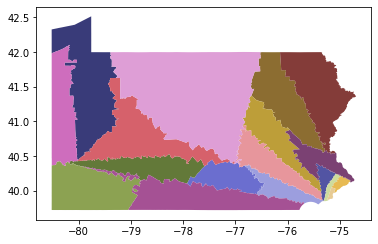

In [94]:
districts_df = all_districts.dissolve(by="SHUFFLED")
districts_df.plot(cmap="tab20b")

In [85]:
# fig, ax = plt.subplots(1, 1)
# base = all_districts.plot(column="SHUFFLED", cmap="tab20b", ax=ax, linewidth=0)
# plt.show()